In [1]:
# Enerjisa Hackathon - Forecast
# 22.04.2022
# Author: Ali Baris Bilen

In [2]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import copy
from sklearn.ensemble import IsolationForest

pd.set_option('display.max_columns', None)

In [160]:
data_path = pathlib.Path('C:/Users/asus/Desktop/kaggle/enerjisa/')

train_df = pd.read_csv(data_path / 'training_data.csv')
future_features_df = pd.read_csv(data_path / 'future_features.csv')

In [4]:
sample_submission = pd.read_csv(data_path / 'sample_submission.csv')

In [5]:
sample_submission['Timestamp'] = pd.to_datetime(sample_submission['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
sample_submission.drop(['Power(kW)'], axis=1, inplace=True) # will be used for joins in the future

In [6]:
submission_path = pathlib.Path('C:/Users/asus/Desktop/kaggle/enerjisa/submissions/')

### Initial Ideas: 

- My assumption is that this wind turbine is located somewhere in the northern Aegean region of Turkey (more specifically, near Çanakkale or Balıkesir). So, if I manage to obtain the wind speed information of that region, it might be helpful for the forecasting model (temperature, humidity can also help).
- I'll use fairly simple models in the beginning, then try more complex models later.
- Since there are 77 columns in the dataset (where I don't even know what they actually mean), dimensionality reduction may be applied in the later steps. Another option might be to fit a random forest model and observe feature importances using its built-in feature importance method.
- Preprocessing (standardization) for the numerical columns and an additional outlier detection process (in addition to what's done in the previous notebook, can improve our forecasting model.

In [ ]:
train_df = train_df.set_index(pd.DatetimeIndex(train_df['Timestamp']))

#### 1) Try Facebook's Prophet

In [7]:
# try prophet using only the time series
# try prophet
prophet_df = pd.DataFrame()

prophet_df['ds'] = train_df['Timestamp'].to_numpy()
prophet_df['y'] = train_df['power'].to_numpy()

# convert to datetime
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y-%m-%d %H:%M:%S.%f')

In [8]:
prophet_df

,ds,y
0,2019-01-01 00:00:00,705.8766
1,2019-01-01 00:10:00,884.7117
2,2019-01-01 00:20:00,982.8750
3,2019-01-01 00:30:00,1115.9434
4,2019-01-01 00:40:00,1263.8417
...,...,...
136725,2021-08-14 23:10:00,2757.7283
136726,2021-08-14 23:20:00,2758.3232
136727,2021-08-14 23:30:00,2759.2434
136728,2021-08-14 23:40:00,2761.2617


In [ ]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(prophet_df)

In [ ]:
future_df = m.make_future_dataframe(periods=17568, freq='10min')

In [ ]:
future_df

In [ ]:
prophet_forecast = m.predict(future_df) # predict

In [ ]:
prophet_plot = m.plot(prophet_forecast) # plot

In [ ]:
prophet_forecast

In [ ]:
# let's see how this will perform

prophet_forecast_submission = prophet_forecast[prophet_forecast['ds'] >= '2021-08-15 00:00:00'][['ds', 'yhat']].rename({'ds': 'Timestamp',
                                                                                                                     'yhat': 'Power(kW)'},
                                                                                                                    axis=1)

prophet_forecast_submission = pd.merge(sample_submission, prophet_forecast_submission, on=['Timestamp'],
                                       how='left', sort=True)

# some NAs are created during the join, I'll interpolate them.
prophet_forecast_submission = prophet_forecast_submission.interpolate(method='pad', axis=0)
prophet_forecast_submission

In [ ]:
prophet_forecast_submission.to_csv(path_or_buf = submission_path / 'prophet_forecast_submission_22_04.csv',
                             index=False, header=True)

In [ ]:
prophet_forecast_submission.isnull().values.any()

Above submission got an RMSE around 1300 and put me out of the first 50 in the leaderboard (best RMSE at the moment being 28). <br>
There is certainly room for improvement :)

In [ ]:
# Let's define a function that keeps the history of forecasting metrics
forecasting_metrics = pd.DataFrame()

def record_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)
    r2_score_ = r2_score(series, forecast)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_, 
             'R2': r2_score_}
    
    df = pd.DataFrame(dict_, index = [model_name])
    df = df.round(decimals = 2)
    
    forecasting_metrics = forecasting_metrics.append(df)

    return forecasting_metrics

I think it's also a good idea to define a method that prepares dataframes to submissions.

#### 2) Try multiple linear regression

In [72]:
train_df['Minute'] = pd.DatetimeIndex(train_df['Timestamp']).minute

In [73]:
train_df_without_ts = train_df.drop(['Timestamp'], axis=1) # since linear regression (in fact, most of the regression models other than ARIMA & S-ARIMA)
# cannot handle datetime objects. That's why I extracted minute to another column and dropped 'Timestamp'.

In [74]:
columns = list(train_df_without_ts.columns)

In [75]:
columns.pop(0)
columns.append('power')

In [76]:
train_df_without_ts = train_df_without_ts.reindex(columns=columns)

In [77]:
train_df_without_ts.head(1)

,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,State and Fault,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Turbine State,Minute,power
0,2,1,1,2019,0,0.0,0.0,0.0,0.0,57.0,59.0,52.0,56.1583,47.0538,57.0,18.8908,35.0,48.5767,56.1583,55.0,55.0,35.8738,-205.35,57.0,-212.1267,28.0,52.6183,264.9498,265.6299,1735.0,-0.953,25.0,20.11,395.03,17.715,392.0867,20.0,20.0,392.4133,10.7733,682.045,11.0,12.0,11.0,72.2102,181.897,15.14,0.0,0.0,2780.0,395.0,0.0,-0.0726,0.0767,3300.0,24.0,-1.5824,3.9767,-0.7617,3138.0,0.0,-2.9233,-3.0117,2.0,-0.319,-0.319,0.2727,0.0555,0.2671,0.0,0.0586,-0.3257,37.8671,39.2811,1.0,0,705.8766


In [125]:
X = train_df_without_ts.iloc[:, :-1].values
y = train_df_without_ts.iloc[:, -1].values

In [126]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41, shuffle=False)

In [127]:
# Training the Multiple Linear Regression model on the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [128]:
# Let's look at RMSE.
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

345.4336969222432

#### 3) Try random forest regression

In [129]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 41)
regressor.fit(X_train, y_train)

# Prediction
y_pred = regressor.predict(X_test)

In [130]:
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

113.9531994987669

RMSE is promising. It can definitely be improved via preprocessing (scaling and/or normalization) and hyperparameter tuning. <br>
Dimensionality reduction can also be applied as there are more than 75 columns.

I'll first look at importance matrix and then apply grid search.

In [49]:
feature_vector = columns[:-1] # take 'power' out

In [51]:
target = 'power'

In [ ]:
# below piece of code takes a couple of minutes
result = permutation_importance(regressor, X, y, n_repeats=10,
                               random_state=41)
#plt.barh(X_train, regressor.feature_importances_)

# Cons of permutation importance;
# more computationally expensive than the default feature_importances
# permutation importance overestimates the importance of correlated predictors — Strobl et al (2008)

In [ ]:
plt.bar([x for x in range(len(result.importances_mean))], result.importances_mean)

In [ ]:
rf_importances = regressor.feature_importances_

# summarize feature importance
for i,v in enumerate(rf_importances):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(rf_importances))], rf_importances)
plt.show()

In [ ]:
feature_vector[65]

In [ ]:
feature_vector[60]

In [ ]:
feature_vector[21] # -> this turned out to be the most (and possibly the only) important variable

Question: How come time features are unimportant in a time series data?

In [ ]:
# I am going to remove all of the columns except those three columns printed above.

In [ ]:
X_v1 = train_df_without_ts[['Torque', 'Pitch Offset-3 Asymmetric Load Controller', 'Scope CH 4']].values

In [ ]:
X_train_v1, X_test_v1, y_train, y_test = train_test_split(X_v1, y, test_size = 0.2, random_state = 41, shuffle=False)

# Training the Multiple Linear Regression model on the Training set
regressor = RandomForestRegressor(n_estimators = 10, random_state = 41)
regressor.fit(X_train_v1, y_train)

# Prediction
y_pred = regressor.predict(X_test_v1)

In [ ]:
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

RMSE has increased over 23%, however, it used ~70 columns fewer than the full model. I think it's promising.

In [ ]:
# let's apply grid search cross validation to not suffer from overfitting.
feature_vector_v1 = ['Torque', 'Pitch Offset-3 Asymmetric Load Controller', 'Scope CH 4']

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 80, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [20, 50, 100]
}

grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train_v1, y_train)

grid_search.best_params_
# 864 combinations tried in total.

In [ ]:
def evaluate_regressor(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
        
    return accuracy

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate_regressor(best_grid, X_test_v1, y_test)

In [ ]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 41, bootstrap=True,
                                 max_depth=40, min_samples_leaf=4, min_samples_split=10, max_features=2)
regressor.fit(X_train_v1, y_train)

# Prediction
y_pred = regressor.predict(X_test_v1)

In [ ]:
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

RMSE has been improved only by 12-13%. <br>
Let's also try this configuration with the full model (although the grid search is run with the sparse model).

In [ ]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 41, bootstrap=True,
                                 max_depth=40, min_samples_leaf=4, min_samples_split=10, max_features=2)
regressor.fit(X_train, y_train)

# Prediction
y_pred = regressor.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

In [ ]:
# No improvement.

---------------

I will try xgboost.

In [ ]:
# Xgb model
model = XGBRegressor()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

In [ ]:
# From 113 (so far the lowest RMSE) to 89.

In [ ]:
xgboost_importances = model.feature_importances_

# summarize feature importance
for i,v in enumerate(xgboost_importances):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(xgboost_importances))], xgboost_importances)
plt.show()

In [53]:
# Important features so far:
print('Important features so far:')
print()
print(feature_vector[69])
print(feature_vector[70])
print(feature_vector[74])
print()
print('****')
print()
print('from the first random forest model')
print(feature_vector[60])
print(feature_vector[65])
print(feature_vector[21])

Important features so far:

Pitch Demand Baseline_Degree
Blade-1 Set Value_Degree
Turbine State

****

from the first random forest model
Pitch Offset-3 Asymmetric Load Controller
Scope CH 4
Torque


In [37]:
# apply grid search

# below piece of code is computationally expensive

params_xg = {"subsample":[0.5, 1],
              "colsample_bytree":[0.5, 1],
              "max_depth":[2, 6],
              "min_child_weight":[1,5],
              "learning_rate":[0.1, 0.03],
              "n_estimators":[20]}

model_gs = GridSearchCV(model,param_grid=params_xg,cv=3,scoring="neg_root_mean_squared_error")
model_gs.fit(X, y)

print(model_gs.best_params_)

{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 20, 'subsample': 0.5}


In [ ]:
# to do:
# 1) apply preprocessing to numerical columns (all of the column in this context)
# 2) fit optimized model to feature set.
# 3) make predictions and report rmse.

# 4) remove unimportant columns and repeat above steps -> because machine learning is highly iterative process.

# an idea: output of the prophet model can be merged to our feature set and can be used as predictor.

In [45]:
# feature scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [29]:
model = XGBRegressor()
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [31]:
y_pred = model.predict(X_test_scaled)

In [32]:
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

89.44964338503458

In [30]:
# Standard scaler didn't help us to improve the RMSE. Let's also try minmax() scaler.

In [42]:
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [73]:
model = XGBRegressor()
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [74]:
y_pred = model.predict(X_test_scaled)
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

89.44964338503458

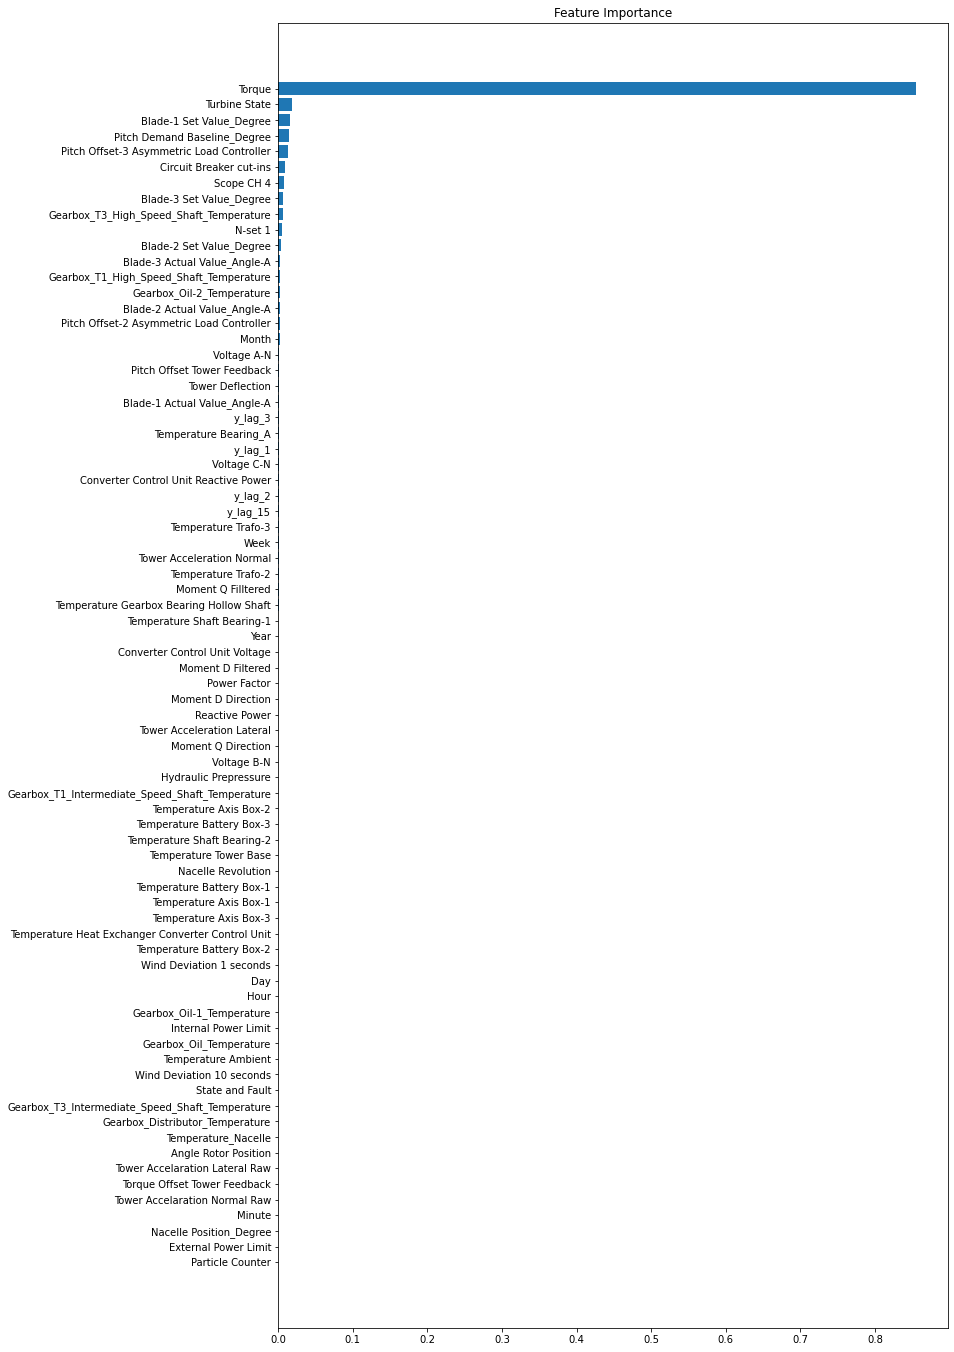

In [81]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_vector)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [38]:
xgb_model_gs = XGBRegressor()
xgb_model_gs.set_params(**model_gs.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None, ...)

In [46]:
xgb_model_gs.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [47]:
y_pred = xgb_model_gs.predict(X_test_scaled)
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

186.86751842170014

In [ ]:
# RMSE got significantly worse compared to the initial model.

In [82]:
X_sparse = train_df_without_ts[['Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                               'Torque',
                                'Circuit Breaker cut-ins',
                               'Blade-1 Set Value_Degree',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                               'N-set 1',
                               'Blade-1 Set Value_Degree']].iloc[:, :-1].values

In [92]:
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(X_sparse, y, test_size = 0.2, random_state = 41, shuffle=False)

In [95]:
X_train_scaled_sparse = sc.fit_transform(X_train_sparse)
X_test_scaled_sparse = sc.transform(X_test_sparse)

sparse_model = XGBRegressor()
sparse_model.fit(X_train_sparse, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [96]:
y_pred = sparse_model.predict(X_test_sparse)
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

88.37106033990298

In [58]:
# -> It appears that taking only important features also didn't help.

In [100]:
# --- Submission preparation ---
xgb_submission_v1 = pd.DataFrame()

xgb_submission_v1['Power(kW)'] = y_pred
xgb_submission_v1['Timestamp'] = train_df['Timestamp']

xgb_submission_v1['Timestamp'] = pd.to_datetime(xgb_submission_v1['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')


xgb_submission_v1 = pd.merge(sample_submission, xgb_submission_v1, on=['Timestamp'],
                                       how='left', sort=True)

# some NAs may be created during the join, I'll interpolate them.
xgb_submission_v1 = xgb_submission_v1.interpolate(method='pad', axis=0)

In [103]:
# write to output file
xgb_submission_v1.to_csv(path_or_buf = submission_path / 'xgb_submission_v1_23_04.csv',
                             index=False, header=True)

Important features: ['Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                               'Torque',
                                'Circuit Breaker cut-ins',
                               'Blade-1 Set Value_Degree',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                               'N-set 1',
                               'Blade-1 Set Value_Degree']]

In [11]:
# back to prophet - but this time I'll add additional regressors
# - I don't want to give up on time series features.

In [12]:
prophet_df['Pitch Demand Baseline_Degree'] = train_df['Pitch Demand Baseline_Degree'].to_numpy()
prophet_df['Blade-1 Set Value_Degree'] = train_df['Blade-1 Set Value_Degree'].to_numpy()
prophet_df['Turbine State'] = train_df['Turbine State'].to_numpy()
prophet_df['Pitch Offset-3 Asymmetric Load Controller'] = train_df['Pitch Offset-3 Asymmetric Load Controller'].to_numpy()
prophet_df['Scope CH 4'] = train_df['Scope CH 4'].to_numpy()
prophet_df['Torque'] = train_df['Torque'].to_numpy()
prophet_df['Circuit Breaker cut-ins'] = train_df['Circuit Breaker cut-ins'].to_numpy()
prophet_df['Blade-1 Set Value_Degree'] = train_df['Blade-1 Set Value_Degree'].to_numpy()
prophet_df['Gearbox_T3_High_Speed_Shaft_Temperature'] = train_df['Gearbox_T3_High_Speed_Shaft_Temperature'].to_numpy()
prophet_df['N-set 1'] = train_df['N-set 1'].to_numpy()
prophet_df['Blade-1 Set Value_Degree'] = train_df['Blade-1 Set Value_Degree'].to_numpy()

In [14]:
new_prophet = Prophet(changepoint_prior_scale=0.01)

In [15]:
# additional regressors
new_prophet.add_regressor('Pitch Demand Baseline_Degree')
new_prophet.add_regressor('Blade-1 Set Value_Degree')
new_prophet.add_regressor('Turbine State')
new_prophet.add_regressor('Pitch Offset-3 Asymmetric Load Controller')
new_prophet.add_regressor('Scope CH 4')
new_prophet.add_regressor('Torque')
new_prophet.add_regressor('Circuit Breaker cut-ins')
new_prophet.add_regressor('Blade-1 Set Value_Degree')
new_prophet.add_regressor('Gearbox_T3_High_Speed_Shaft_Temperature')
new_prophet.add_regressor('N-set 1')
new_prophet.add_regressor('Blade-1 Set Value_Degree')

In [16]:
new_prophet.fit(prophet_df)

In [34]:
new_future_df = new_prophet.make_future_dataframe(periods=17568, freq='10min')

In [35]:
new_future_df

,ds
0,2019-01-01 00:00:00
1,2019-01-01 00:10:00
2,2019-01-01 00:20:00
3,2019-01-01 00:30:00
4,2019-01-01 00:40:00
...,...
154293,2021-12-14 23:10:00
154294,2021-12-14 23:20:00
154295,2021-12-14 23:30:00
154296,2021-12-14 23:40:00


In [36]:
future_features_df_prophet = future_features_df.rename({'Timestamp':'ds'}, axis=1)
future_features_df_prophet['ds'] = pd.to_datetime(future_features_df_prophet['ds'], format='%Y-%m-%d %H:%M:%S.%f')

In [50]:
future_features_df_prophet

,ds,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,State and Fault,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Turbine State
0,2021-08-15 00:00:00,60.0683,62.0000,56.0000,58.0000,125.2187,60.0000,64.7073,54.3483,121.0000,58.0000,56.0000,56.0000,100.9584,567.0883,128.0000,535.3600,48.0,47.0000,261.2227,264.7704,1735.0,0.9798,43.0000,31.0033,407.4767,37.0,403.9000,37.0,38.0,402.0683,342.4283,702.2850,37.0,38.0000,38.0,87.6400,179.5626,29.4683,0.0024,-0.0003,2780.0,636.0,1.0,3.8526,-0.2433,3300.0,31.0000,-0.3906,22.0000,-0.8405,2952.0,-0.0052,-1.7433,-1.8333,2.0,8.2698,8.2698,9.4945,9.0209,9.4932,8.9251,9.0145,8.2666,-41.8619,-37.9177,1.0
1,2021-08-15 00:10:00,60.0000,62.0000,56.0000,57.0367,145.1603,59.2800,64.1275,58.0983,120.9717,57.0367,55.2750,55.2750,100.3291,324.8883,128.0000,294.0017,48.0,47.0000,270.8717,271.3471,1735.0,0.9890,43.0000,31.0000,405.0350,37.0,401.1833,37.0,38.0,399.8467,342.0000,697.9517,37.0,37.9267,38.0,87.3711,178.7765,29.2150,0.0036,0.0012,2780.0,636.0,1.0,2.6982,0.4927,3300.0,31.0000,-0.8276,22.0000,-0.8417,2952.0,-0.0049,-0.3350,-0.3400,2.0,6.2936,6.2936,7.5163,7.0311,7.5074,6.9377,7.0224,6.2870,-19.2108,-19.6023,1.0
2,2021-08-15 00:20:00,60.0000,62.0000,55.8533,57.0000,129.2399,59.0000,54.5631,60.3600,120.0283,57.0000,55.0000,55.0000,100.4440,361.4050,127.5517,331.3533,48.0,46.9000,264.6733,265.5493,1735.0,0.9899,43.0000,31.0000,405.6600,37.0,401.7733,37.0,38.0,400.1433,342.0000,698.7466,37.0,37.0000,38.0,87.1231,178.4476,29.1600,0.0035,-0.0001,2780.0,636.0,1.0,2.0187,0.0483,3300.0,31.0000,-2.3240,22.0000,-0.8417,2952.0,-0.0054,-0.8300,-0.8633,2.0,6.8418,6.8418,8.0602,7.5799,8.0658,7.4974,7.5814,6.8448,-28.1441,-34.3291,1.0
3,2021-08-15 00:30:00,60.0000,62.0000,55.0000,57.0000,140.1516,59.0000,61.8993,61.7150,120.0000,57.0000,55.0000,55.0000,100.5905,361.0533,127.0000,329.5383,48.0,46.2850,244.3360,240.0289,1735.0,0.9900,43.0000,31.0000,405.6017,37.0,401.7733,37.0,38.0,400.2383,344.3000,698.8267,37.0,37.0000,38.0,86.8652,179.2657,29.0333,-0.0031,-0.0004,2780.0,636.0,1.0,0.6927,-0.7347,3300.0,31.0000,-0.4833,22.0000,-0.8353,2952.0,0.0009,-2.3100,-2.3050,2.0,6.9027,6.9027,8.1313,7.6562,8.1325,7.5658,7.6544,6.9092,-7.5925,-11.7184,1.0
4,2021-08-15 00:40:00,60.0000,62.0000,55.0000,57.0000,126.1247,59.0000,56.8045,62.6983,120.0000,57.0000,55.0000,55.0000,101.0755,341.2150,127.0000,309.5783,48.0,46.4633,243.5518,240.6191,1735.0,0.9900,42.9833,31.0000,405.2617,37.0,401.4300,37.0,38.0,400.0333,343.0000,698.37

In [52]:
# aligning prophet future df with our feature df
new_future_df = new_future_df[new_future_df['ds'] >= '2021-08-15 00:00:00']

In [53]:
new_future_df

,ds
136730,2021-08-15 00:00:00
136731,2021-08-15 00:10:00
136732,2021-08-15 00:20:00
136733,2021-08-15 00:30:00
136734,2021-08-15 00:40:00
...,...
154293,2021-12-14 23:10:00
154294,2021-12-14 23:20:00
154295,2021-12-14 23:30:00
154296,2021-12-14 23:40:00


In [ ]:
# didn't understand why row counts are different. anyway, only common datetimes will remain when we join
# the prediction dataframe with sample submission df.

In [57]:
new_future_df = new_future_df.set_index('ds').join(future_features_df_prophet.set_index('ds'), how='inner', on= ['ds'])

In [60]:
new_future_df['ds'] = new_future_df.index

In [64]:
new_prophet_forecast = new_prophet.predict(new_future_df) # predict

In [65]:
new_prophet_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Blade-1 Set Value_Degree,Blade-1 Set Value_Degree_lower,Blade-1 Set Value_Degree_upper,Circuit Breaker cut-ins,Circuit Breaker cut-ins_lower,Circuit Breaker cut-ins_upper,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature_lower,Gearbox_T3_High_Speed_Shaft_Temperature_upper,N-set 1,N-set 1_lower,N-set 1_upper,Pitch Demand Baseline_Degree,Pitch Demand Baseline_Degree_lower,Pitch Demand Baseline_Degree_upper,Pitch Offset-3 Asymmetric Load Controller,Pitch Offset-3 Asymmetric Load Controller_lower,Pitch Offset-3 Asymmetric Load Controller_upper,Scope CH 4,Scope CH 4_lower,Scope CH 4_upper,Torque,Torque_lower,Torque_upper,Turbine State,Turbine State_lower,Turbine State_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-08-15 00:00:00,1926.137656,1420.758923,2685.651980,1926.137656,1926.137656,-43.098763,-43.098763,-43.098763,-797.702627,-797.702627,-797.702627,484.195635,484.195635,484.195635,172.701061,172.701061,172.701061,-41.641551,-41.641551,-41.641551,37.508539,37.508539,37.508539,-41.734073,-41.734073,-41.734073,253.305590,253.305590,253.305590,-0.166057,-0.166057,-0.166057,136.277524,136.277524,136.277524,-60.536422,-60.536422,-60.536422,23.367754,23.367754,23.367754,1.816240,1.816240,1.816240,171.629952,171.629952,171.629952,0.0,0.0,0.0,2062.415180
1,2021-08-15 00:10:00,1926.142909,1356.602701,2650.429849,1926.142909,1926.142909,-62.914332,-62.914332,-62.914332,-797.702627,-797.702627,-797.702627,484.195635,484.195635,484.195635,172.701061,172.701061,172.701061,-60.777387,-60.777387,-60.777387,35.232764,35.232764,35.232764,-60.216906,-60.216906,-60.216906,251.292165,251.292165,251.292165,-0.166057,-0.166057,-0.166057,70.532224,70.532224,70.532224,-64.491494,-64.491494,-64.491494,-38.355685,-38.355685,-38.355685,1.716719,1.716719,1.716719,171.662685,171.662685,171.662685,0.0,0.0,0.0,1996.675133
2,2021-08-15 00:20:00,1926.148161,1362.682751,2619.774636,1926.148161,1926.148161,-57.353917,-57.353917,-57.353917,-797.702627,-797.702627,-797.702627,484.195635,484.195635,484.195635,172.701061,172.701061,172.701061,-55.388272,-55.388272,-55.388272,39.025723,39.025723,39.025723,-55.089748,-55.089748,-55.089748,251.659784,251.659784,251.659784,-0.166057,-0.166057,-0.166057,87.027112,87.027112,87.027112,-68.165726,-68.165726,-68.165726,-18.118419,-18.118419,-18.118419,1.615851,1.615851,1.615851,171.695406,171.695406,171.695406,0.0,0.0,0.0,2013.175273
3,2021-08-15 00:30:00,1926.153414,1299.665352,2619.400795,1926.153414,1926.153414,-56.627780,-56.627780,-56.627780,-797.702627,-797.702627,-797.702627,484.195635,484.195635,484.195635,172.701061,172.701061,172.701061,-54.729677,-54.729677,-54.729677,-8.765561,-8.765561,-8.765561,-54.520168,-54.520168,-54.520168,252.128506,252.128506,252.128506,-0.166057,-0.166057,-0.166057,38.218341,38.218341,38.218341,-71.536792,-71.536792,-71.536792,-63.486669,-63.486669,-63.486669,1.513685,1.513685,1.513685,171.728117,171.728117,171.728117,0.0,0.0,0.0,1964.371755
4,2021-08-15 00:40:00,1926.158666,1400.991936,2687.852529,1926.158666,1926.158666,-42.605388,-42.605388,-42.605388,-797.702627,-797.702627,-797.702627,484.195635,484.195635,484.195635,172.701061,172.701061,172.701061,-41.163011,-41.163011,-41.163011,27.646846,27.646846,27.646846,-41.305718,-41.305718,-41.305718,253.680247,253.680247,253.680247,-0.166057,-0.166057,-0.166057,113.866131,113.866131,113.866131,-74.585945,-74.585945,-74.585945,15.280988,15.280988,15.280988,1.410271,1.410271,1.410271,171.760817,171.760817,171.760817,0.0,0.0,0.0,2040.024798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [67]:
# let's see how this will perform
new_prophet_forecast_submission = new_prophet_forecast[['ds', 'yhat']].rename({'ds': 'Timestamp',
                                                                               'yhat': 'Power(kW)'},
                                                                              axis=1)

new_prophet_forecast_submission = pd.merge(sample_submission, new_prophet_forecast_submission, on=['Timestamp'],
                                       how='left', sort=True)

# some NAs are created during the join, I'll interpolate them.
new_prophet_forecast_submission = new_prophet_forecast_submission.interpolate(method='pad', axis=0)

In [69]:
new_prophet_forecast_submission.to_csv(path_or_buf = submission_path / 'prophet_forecast_submission_25_04.csv',
                             index=False, header=True)

In [70]:
# it did quite worse (RMSE=560). I should go back to my xgboost model try to figure out what prevents RMSE to decrease further.
# maybe collinearity? however this shouldn't be a concern as xgboost is not a linear model.

This time I'll not use train_test_split.

In [111]:
X = train_df_without_ts[['Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                               'Torque',
                                'Circuit Breaker cut-ins',
                               'Blade-1 Set Value_Degree',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                               'N-set 1',
                               'Blade-1 Set Value_Degree', 'power']].iloc[:, :-1].values
y = train_df_without_ts.iloc[:, -1].values

In [112]:
future_features_df_without_ts = future_features_df.drop(['Timestamp'], axis=1)

In [113]:
X_presplit_test = future_features_df_without_ts[['Pitch Demand Baseline_Degree',  # I named it as pre split because it was given by the data supplier
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                               'Torque',
                                'Circuit Breaker cut-ins',
                               'Blade-1 Set Value_Degree',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                               'N-set 1',
                               'Blade-1 Set Value_Degree']].values # written twice :/

In [114]:
xgb_model_new = XGBRegressor()

In [115]:
xgb_model_new.fit(X, y) # fit the base xgb model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [117]:
y_pred = xgb_model_new.predict(X_presplit_test)

In [118]:
new_xgboost_forecasts = pd.DataFrame()
new_xgboost_forecasts['Timestamp'] = future_features_df['Timestamp'].to_numpy()
new_xgboost_forecasts['Power(kW)'] = y_pred

In [122]:
new_xgboost_forecasts = new_xgboost_forecasts.interpolate(method='pad', axis=0)

In [124]:
new_xgboost_forecasts.to_csv(path_or_buf = submission_path / 'new_xgboost_submission_25_04.csv',
                             index=False, header=True)

RMSE came up 80. Best submission on the leaderboard got 19. <br>
I'm unsure about how to improve this model further. <br>
At least I proved that splitting train_df into train and test & using the pre-split dataframes produce similar RMSE values.

In [ ]:
# I'm adding the least important features too, to see if they can provide me some predictive power.

In [153]:
train_df_without_ts

,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,State and Fault,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Turbine State,Minute,power
0,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,57.0000,59.0000,52.0000,56.1583,47.0538,57.0000,18.8908,35.0000,48.5767,56.1583,55.0000,55.0000,35.8738,-205.3500,57.0,-212.1267,28.0000,52.6183,264.9498,265.6299,1735.0,-0.9530,25.0,20.110,395.0300,17.7150,392.0867,20.00,20.0000,392.4133,10.7733,682.0450,11.0,12.0,11.0,72.2102,181.8970,15.1400,0.0000,0.0000,2780.0,395.0,0.0,-0.0726,0.0767,3300.0,24.0000,-1.5824,3.9767,-0.7617,3138.0,0.0000,-2.9233,-3.0117,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,37.8671,39.2811,1.0,0,705.8766
1,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,57.6933,59.4850,52.4500,57.0000,64.9697,57.4133,28.5603,35.2333,48.0000,57.0000,55.1750,55.1750,41.3705,-176.2233,57.0,-183.4033,28.0000,53.0600,3.3404,3.0551,1735.0,-0.9719,25.0,20.425,396.1333,17.4600,392.9317,20.00,20.0000,393.0400,4.9767,683.5150,11.0,12.0,11.0,72.2205,178.2247,14.9483,0.0000,0.0000,2780.0,395.0,0.0,2.6322,0.3232,3300.0,24.0000,-2.2313,4.0000,-0.7778,3138.0,0.0000,-3.0333,-2.9750,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,-90.1691,-89.0187,1.0,10,884.7117
2,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,59.0000,60.7567,53.5367,57.7750,51.1497,58.7283,34.2288,36.0000,48.0533,57.7750,56.0000,56.0000,44.4662,-105.0583,57.0,-112.1433,28.7633,54.0000,75.6490,75.4351,1735.0,-0.9889,25.0,21.000,397.1383,18.0000,394.0283,20.00,20.0000,393.9417,0.6367,685.2450,11.0,12.0,11.0,72.3649,184.1830,14.1717,0.0000,0.0000,2780.0,395.0,0.0,2.1176,-0.0322,3300.0,24.0000,-2.4696,4.0000,-0.7899,3138.0,0.0000,1.0533,1.0283,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,-88.5563,-88.4220,1.0,20,982.8750
3,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,59.8817,61.5633,54.4133,58.6833,58.7409,59.5183,35.5932,36.0000,48.7883,58.6833,56.7383,56.7383,48.2599,-150.9233,57.0,-157.7833,29.0000,54.8200,192.7079,192.8657,1735.0,-0.9857,25.0,21.100,397.0717,18.0000,393.8067,20.00,20.0000,393.8233,3.9767,684.9384,11.0,12.0,11.0,72.4586,182.4283,14.3100,0.0000,0.0000,2780.0,395.0,0.0,3.0610,-0.6349,3300.0,24.0000,-2.0260,3.9850,-0.7806,3138.0,0.0000,-1.3733,-1.3467,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,-123.7553,-124.8584,1.0,30,1115.9434
4,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,61.2900,62.5867,55.4850,59.6233,53.2648,60.6650,38.5

In [171]:
# in the previous sparse model, blade-1 set value degree was included twice (by mistake) in the training matrix, now I fix it.
X_sparse = train_df_without_ts_v2[['Torque',
                                   'Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                                'Circuit Breaker cut-ins',
                               'Blade-3 Set Value_Degree',
                                'Blade-2 Set Value_Degree',
                                'Blade-3 Actual Value_Angle-A',
                                'Gearbox_T1_High_Speed_Shaft_Temperature',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                                'Gearbox_Oil-2_Temperature',
                                'Blade-2 Actual Value_Angle-A',
                               'N-set 1',
                               'Pitch Offset-3 Asymmetric Load Controller']].iloc[:, :-1].values

X_sparse_train, X_sparse_test , y_train, y_test = train_test_split(X_sparse, y, test_size = 0.3, random_state = 41, shuffle=False)

In [190]:
sparse_xgb_model = XGBRegressor(random_state=41, eval_metric='rmse')
sparse_xgb_model.fit(X_sparse_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=41,
             reg_alpha=0, reg_lambda=1, ...)

In [191]:
y_pred = sparse_xgb_model.predict(X_sparse_test)
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

98.52940416080341

In [192]:
# RMSE = 98.

In [193]:
# I'll add monotonic constraint (a positive one) on 'Torque' hoping that this will improve the RMSE of the model.

In [194]:
#sparse_xgb_model = XGBRegressor(booster='gbtree', importance_type='gain',
#                               learning_rate=0.3, max_depth=6, min_child_weight=1,
#                               n_estimators=100, random_state=41, eval_metric='rmse',
#                               monotone_constraints = (1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0))
#sparse_xgb_model.fit(X_sparse_train, y_train)

It didn't work out.

-----------------------------------------------

At this step, I've got two more things to try. One is outlier detection, and other is trying <br> 
a more complex model such as ANN (artificial neural network) or LSTM (long short term memory).

In [197]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1
X_train_outlier, y_train_outlier = X_train[mask, :], y_train[mask]

In [206]:
xgb_model_outlier = XGBRegressor(random_state=41, eval_metric='rmse')
xgb_model_outlier.fit(X_train_outlier, y_train_outlier)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=41,
             reg_alpha=0, reg_lambda=1, ...)

In [207]:
y_pred = xgb_model_outlier.predict(X_test)
mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average', squared=False)

145.1850593843244

In [208]:
# RMSE = 135. this also didn't improve the model.

I'll now try LSTM network. This will be the first LSTM model I've ever built. <br>
I don't have any deep knowledge over LSTM to be honest.

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [16]:
import tensorflow as tf

In [9]:
train_df_lstm = train_df.drop(['Timestamp'], axis=1)

In [10]:
train_df_lstm

,power,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,State and Fault,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Turbine State
0,705.8766,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,57.0000,59.0000,52.0000,56.1583,47.0538,57.0000,18.8908,35.0000,48.5767,56.1583,55.0000,55.0000,35.8738,-205.3500,57.0,-212.1267,28.0000,52.6183,264.9498,265.6299,1735.0,-0.9530,25.0,20.110,395.0300,17.7150,392.0867,20.00,20.0000,392.4133,10.7733,682.0450,11.0,12.0,11.0,72.2102,181.8970,15.1400,0.0000,0.0000,2780.0,395.0,0.0,-0.0726,0.0767,3300.0,24.0000,-1.5824,3.9767,-0.7617,3138.0,0.0000,-2.9233,-3.0117,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,37.8671,39.2811,1.0
1,884.7117,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,57.6933,59.4850,52.4500,57.0000,64.9697,57.4133,28.5603,35.2333,48.0000,57.0000,55.1750,55.1750,41.3705,-176.2233,57.0,-183.4033,28.0000,53.0600,3.3404,3.0551,1735.0,-0.9719,25.0,20.425,396.1333,17.4600,392.9317,20.00,20.0000,393.0400,4.9767,683.5150,11.0,12.0,11.0,72.2205,178.2247,14.9483,0.0000,0.0000,2780.0,395.0,0.0,2.6322,0.3232,3300.0,24.0000,-2.2313,4.0000,-0.7778,3138.0,0.0000,-3.0333,-2.9750,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,-90.1691,-89.0187,1.0
2,982.8750,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,59.0000,60.7567,53.5367,57.7750,51.1497,58.7283,34.2288,36.0000,48.0533,57.7750,56.0000,56.0000,44.4662,-105.0583,57.0,-112.1433,28.7633,54.0000,75.6490,75.4351,1735.0,-0.9889,25.0,21.000,397.1383,18.0000,394.0283,20.00,20.0000,393.9417,0.6367,685.2450,11.0,12.0,11.0,72.3649,184.1830,14.1717,0.0000,0.0000,2780.0,395.0,0.0,2.1176,-0.0322,3300.0,24.0000,-2.4696,4.0000,-0.7899,3138.0,0.0000,1.0533,1.0283,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,-88.5563,-88.4220,1.0
3,1115.9434,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,59.8817,61.5633,54.4133,58.6833,58.7409,59.5183,35.5932,36.0000,48.7883,58.6833,56.7383,56.7383,48.2599,-150.9233,57.0,-157.7833,29.0000,54.8200,192.7079,192.8657,1735.0,-0.9857,25.0,21.100,397.0717,18.0000,393.8067,20.00,20.0000,393.8233,3.9767,684.9384,11.0,12.0,11.0,72.4586,182.4283,14.3100,0.0000,0.0000,2780.0,395.0,0.0,3.0610,-0.6349,3300.0,24.0000,-2.0260,3.9850,-0.7806,3138.0,0.0000,-1.3733,-1.3467,2.0,-0.3190,-0.3190,0.2727,0.0555,0.2671,0.0000,0.0586,-0.3257,-123.7553,-124.8584,1.0
4,1263.8417,2,1,1,2019,0,0.000,0.0000,0.0000,0.0000,61.2900,62.5867,55.4850,59.6233,53.2648,60.6650,38.5527,36.0

In [11]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(train_df_lstm[['Torque',
                                   'Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                                'Circuit Breaker cut-ins',
                               'Blade-3 Set Value_Degree',
                                'Blade-2 Set Value_Degree',
                                'Blade-3 Actual Value_Angle-A',
                                'Gearbox_T1_High_Speed_Shaft_Temperature',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                                'Gearbox_Oil-2_Temperature',
                                'Blade-2 Actual Value_Angle-A',
                               'N-set 1',
                               'Pitch Offset-3 Asymmetric Load Controller']])
Y_data = Y_scaler.fit_transform(train_df_lstm[['power']])

In [39]:
validate = train_df_lstm[['Torque',
                                   'Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                                'Circuit Breaker cut-ins',
                               'Blade-3 Set Value_Degree',
                                'Blade-2 Set Value_Degree',
                                'Blade-3 Actual Value_Angle-A',
                                'Gearbox_T1_High_Speed_Shaft_Temperature',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                                'Gearbox_Oil-2_Temperature',
                                'Blade-2 Actual Value_Angle-A',
                               'N-set 1',
                               'Pitch Offset-3 Asymmetric Load Controller', 'power']].tail(10)
#train_df_lstm.drop(train_df_lstm.tail(10).index,inplace=True)

In [12]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [13]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 100000
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [14]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[8.47502243e-01 0.00000000e+00 1.41914362e-03 0.00000000e+00
  8.80632411e-01 4.98192711e-01 0.00000000e+00 7.49222222e-03
  1.55666105e-05 4.98192991e-01 7.66939239e-01 7.63454015e-01
  7.58164852e-01 3.24195353e-03 1.00000000e+00 8.80632411e-01]
 [8.60315933e-01 0.00000000e+00 1.41914362e-03 0.00000000e+00
  8.80632411e-01 4.98192711e-01 0.00000000e+00 7.49222222e-03
  1.55666105e-05 4.98192991e-01 7.80367062e-01 7.72485117e-01
  7.66199456e-01 3.24195353e-03 1.00000000e+00 8.80632411e-01]
 [8.67532506e-01 0.00000000e+00 1.41914362e-03 0.00000000e+00
  8.80632411e-01 4.98192711e-01 0.00000000e+00 7.49222222e-03
  1.55666105e-05 4.98192991e-01 8.05675207e-01 7.96165226e-01
  7.91763219e-01 3.24195353e-03 1.00000000e+00 8.80632411e-01]
 [8.76376230e-01 0.00000000e+00 1.41914362e-03 0.00000000e+00
  8.80632411e-01 4.98192711e-01 0.00000000e+00 7.49222222e-03
  1.55666105e-05 4.98192991e-01 8.22751958e-01 8.11184788e-01
  8.07120918e-01 3.24195353e-03 1.

In [17]:
batch_size = 256
buffer_size = 150

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [18]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')

In [19]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 400)          347200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 48, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 20)                6020      
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0

In [20]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [22]:
history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - 117s 1s/step - loss: 0.0986 - val_loss: 0.0654
Epoch 2/10
100/100 [==============================] - 112s 1s/step - loss: 0.0853 - val_loss: 0.0575
Epoch 3/10
100/100 [==============================] - 115s 1s/step - loss: 0.0539 - val_loss: 0.1751
Epoch 4/10
100/100 [==============================] - 126s 1s/step - loss: 0.0674 - val_loss: 0.0514
Epoch 5/10
100/100 [==============================] - 123s 1s/step - loss: 0.0468 - val_loss: 0.0608
Epoch 6/10
100/100 [==============================] - 120s 1s/step - loss: 0.0426 - val_loss: 0.0364
Epoch 7/10
100/100 [==============================] - 114s 1s/step - loss: 0.0391 - val_loss: 0.0826
Epoch 8/10
100/100 [==============================] - 113s 1s/step - loss: 0.0473 - val_loss: 0.0574
Epoch 9/10
100/100 [==============================] - 115s 1s/step - loss: 0.0391 - val_loss: 0.0297
Epoch 10/10
100/100 [==============================] - 117s 1s/step - loss: 0.0333 - val_lo

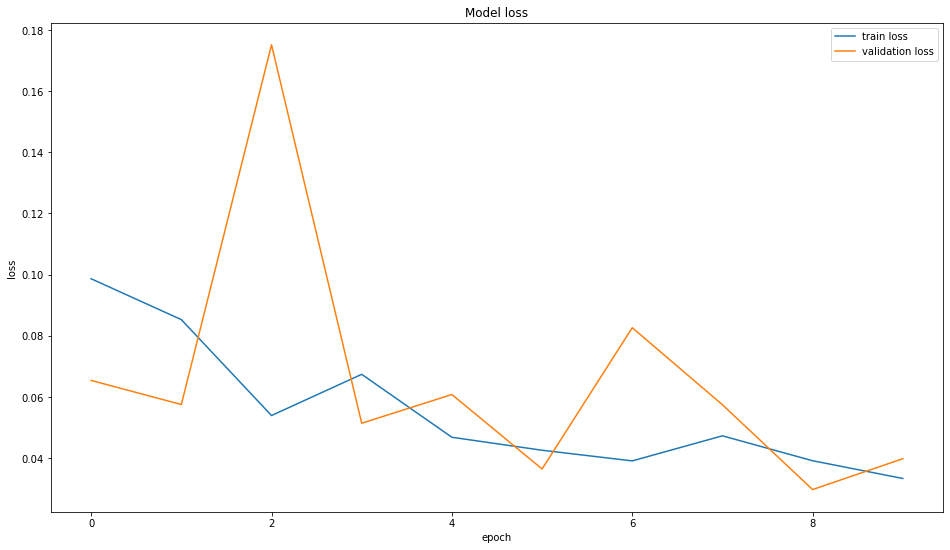

In [24]:
# plot
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [30]:
# Look at the last 48 observations and evaluate the model
train_df_lstm_val = X_scaler.fit_transform(train_df_lstm[['Torque',
                                   'Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                                'Circuit Breaker cut-ins',
                               'Blade-3 Set Value_Degree',
                                'Blade-2 Set Value_Degree',
                                'Blade-3 Actual Value_Angle-A',
                                'Gearbox_T1_High_Speed_Shaft_Temperature',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                                'Gearbox_Oil-2_Temperature',
                                'Blade-2 Actual Value_Angle-A',
                               'N-set 1',
                               'Pitch Offset-3 Asymmetric Load Controller']].tail(48))
val_rescaled = train_df_lstm_val.reshape(1, train_df_lstm_val.shape[0], train_df_lstm_val.shape[1])

In [31]:
# prediction
pred_lstm = lstm_model.predict(val_rescaled)
pred_lstm

array([[0.04003938, 0.04457949, 0.04334998, 0.02573068, 0.03454505,
        0.03838643, 0.04226557, 0.05625947, 0.04417416, 0.04546544]],
      dtype=float32)

In [32]:
# scale back to original scale
pred_lstm_Inverse = Y_scaler.inverse_transform(pred_lstm)

In [45]:
pred_lstm_Inverse[0]

array([ 72.54764 ,  86.284355,  82.56431 ,  29.254833,  55.923843,
        67.546455,  79.28329 , 121.62364 ,  85.05796 ,  88.964905],
      dtype=float32)

In [52]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')

In [55]:
timeseries_evaluation_metrics_func(validate['power'],pred_lstm_Inverse[0])

Evaluation metric results:-
MSE is : 7193047.990554867
RMSE is : 2681.985829670781
MAPE is : 97.21261291374068


In [46]:
validate['power']

136720    2757.0317
136721    2761.1716
136722    2759.3750
136723    2756.7017
136724    2758.5833
136725    2757.7283
136726    2758.3232
136727    2759.2434
136728    2761.2617
136729    2758.5933
Name: power, dtype: float64

----------------------------

I couldn't make LSTM perform well. <br>
<br>
Now I'll try a different, custom approach.

In [56]:
# Final trial
# Ensemble approach:
# 1) Time series forecast with Prophet.
# 2) Subtract Prophet predictions (historical forecasts) from the original time series.
# 3) Fit XGBoost model to new series, using only important features (Torque and the others).
# 4) Evaluate the results and fine tune both models.
# 5) Forecast the future with Prophet, forecast the residuals with XGBoost and sum them up.
# 6) Submit predictions and observe RMSE.

In [57]:
# step 1: prepare data for Prophet

train_df = train_df.set_index(pd.DatetimeIndex(train_df['Timestamp']))
prophet_df = pd.DataFrame()

prophet_df['ds'] = train_df['Timestamp'].to_numpy()
prophet_df['y'] = train_df['power'].to_numpy()

# convert to datetime
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y-%m-%d %H:%M:%S.%f')

In [92]:
prophet_df_train = prophet_df[prophet_df['ds'] < '2021-01-01 00:00:00'] # -> this is our training set.

In [93]:
prophet_df_train

,ds,y
0,2019-01-01 00:00:00,705.8766
1,2019-01-01 00:10:00,884.7117
2,2019-01-01 00:20:00,982.8750
3,2019-01-01 00:30:00,1115.9434
4,2019-01-01 00:40:00,1263.8417
...,...,...
104429,2020-12-31 23:10:00,2266.0818
104430,2020-12-31 23:20:00,2353.3066
104431,2020-12-31 23:30:00,2315.5134
104432,2020-12-31 23:40:00,2386.8884


In [94]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(prophet_df_train)

In [125]:
# we take up to 2021-08-14 23:50:00, which will be our test dataset
prophet_df_test = m.make_future_dataframe(periods=32544, freq='10min')

Recap: <br>
For this ensemble approach; <br>
Between the start of the series and 2021-01-01 00:00:00 is our training set. <br>
Between 2021-01-01 00:00:00 (included) and 2021-08-14 23:50:00 is our test set.

In [213]:
prophet_df_test

,ds
0,2019-01-01 00:00:00
1,2019-01-01 00:10:00
2,2019-01-01 00:20:00
3,2019-01-01 00:30:00
4,2019-01-01 00:40:00
...,...
136973,2021-08-14 23:10:00
136974,2021-08-14 23:20:00
136975,2021-08-14 23:30:00
136976,2021-08-14 23:40:00


In [127]:
# predict the test dataset
prophet_forecast = m.predict(prophet_df_test) # predict

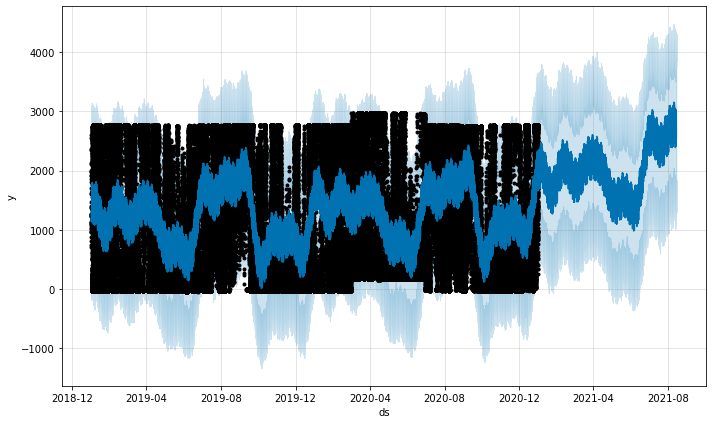

In [128]:
prophet_plot = m.plot(prophet_forecast) # plot

In [172]:
prophet_forecast_series_train = prophet_forecast[['ds', 'yhat']].rename({'ds': 'Timestamp', 'yhat': 'power_to_be_subtracted'}, axis=1)

In [173]:
prophet_forecast_series_train

,Timestamp,power_to_be_subtracted
0,2019-01-01 00:00:00,1284.375297
1,2019-01-01 00:10:00,1269.326089
2,2019-01-01 00:20:00,1255.185760
3,2019-01-01 00:30:00,1242.014635
4,2019-01-01 00:40:00,1229.859123
...,...,...
136973,2021-08-14 23:10:00,2656.301104
136974,2021-08-14 23:20:00,2636.311996
136975,2021-08-14 23:30:00,2616.768671
136976,2021-08-14 23:40:00,2597.781716


In [201]:
# step 2: subtract prophet predictions from the original series
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
train_df = train_df.set_index(pd.DatetimeIndex(train_df['Timestamp']))

prophet_forecast_series_train = prophet_forecast_series_train.set_index(pd.DatetimeIndex(prophet_forecast_series_train['Timestamp']))

In [202]:
train_df_modified = train_df.drop(['Timestamp'], axis=1).join(prophet_forecast_series_train.drop(['Timestamp'], axis=1), on='Timestamp', how='left')

In [203]:
train_df_modified.tail()

,power,Day,Week,Month,Year,Hour,y_lag_15,y_lag_1,y_lag_2,y_lag_3,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,State and Fault,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Turbine State,power_to_be_subtracted
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-14 23:10:00,2757.7283,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433,61.0,63.0000,56.0417,58.0,153.2872,60.0,69.7627,49.0000,121.0,58.0,56.0,56.0,101.0266,588.0967,128.0,557.1183,48.0,48.0000,258.4825,261.4168,1735.0,0.9767,43.0,32.00,407.8783,38.0000,404.2217,38.00,39.0000,402.3517,343.6433,702.8834,37.0,38.0,38.0,89.1103,181.2095,30.0000,0.0048,-0.0003,2780.0,636.0,1.0,0.1979,-0.0766,3300.0,32.0000,-3.7673,22.0,-0.8371,2952.0,0.0003,-1.1200,-1.1017,2.0,9.7963,9.7963,10.9969,10.5313,11.0025,10.4474,10.5361,9.8025,-32.0861,-31.4242,1.0,2656.301104
2021-08-14 23:20:00,2758.3232,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433,61.0,62.3933,56.0000,58.0,155.1184,60.0,82.9372,49.0000,121.0,58.0,56.0,56.0,101.0476,590.0100,128.0,558.0483,48.0,48.0000,270.0011,267.6882,1735.0,0.9768,43.0,32.00,407.7533,38.0000,404.1267,38.00,39.0000,402.3283,343.6550,702.7983,37.0,38.0,38.0,88.7726,180.9491,30.0000,-0.0013,0.0004,2780.0,636.0,1.0,0.4552,0.0052,3300.0,31.0667,-2.1319,22.0,-0.8371,2952.0,0.0021,-1.3650,-1.3667,2.0,10.6219,10.6219,11.8307,11.3697,11.8289,11.2730,11.3685,10.6227,-23.8895,-22.2317,1.0,2636.311996
2021-08-14 23:30:00,2759.2434,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433,61.0,62.0000,56.0000,58.0,156.1390,60.0,74.5021,49.0000,121.0,58.0,56.0,56.0,101.0081,600.1400,128.0,568.3400,48.0,48.0000,262.5582,265.1932,1735.0,0.9735,43.0,32.00,407.9167,37.5783,404.2383,38.00,39.0000,402.5583,343.6950,702.9017,37.0,38.0,38.0,88.4236,176.8642,30.0000,0.0005,-0.0001,2780.0,636.0,1.0,1.5899,0.1730,3300.0,31.0000,-0.6356,22.0,-0.8370,2952.0,-0.0005,-0.6650,-0.6933,2.0,12.0956,12.0956,13.3027,12.8433,13.3003,12.7431,12.8391,12.0897,-4.7172,-5.5532,1.0,2616.768671
2021-08-14 23:40:00,2761.2617,6,32,8,2021,23,1121.615,2565.9551,1007.1967,157.8433,61.0,62.0000,56.0000,58.0,143.4708,60.0,81.6496,49.0000,121.0,58.0,56.0,56.0,101.0946,577.7200,128.0,546.4817,48.0,48.0000,235.0390,241.7890,1735.0,0.9794,43.0,32.00,407.6733,37.0000,404.0183,37.94,39.0000,402.1667,343.6667,702.5067,37.0,38.0,38.0,88.1098,179.4775,30.0000,-0.0045,-0.0005,2780.0,636.0,1.0,1.6360,-0.5885,3300.0,31.0000,-3.2641,22.0,-0.8370,2952.0,0.0054,-1.0483,-1.073

In [204]:
# subtract prophet predictions to obtain residuals
train_df_modified['new_power'] = train_df_modified['power'] - train_df_modified['power_to_be_subtracted']

train_df_modified = train_df_modified.interpolate(method='pad', axis=0) # interpolate NAs. prophet produces 3 NAs unfortunately.

In [207]:
# define feature vector
# -> no scaling has been applied since XGBoost handles original series sufficiently well.
X_new_train = train_df_modified[train_df_modified.index < '2021-01-01 00:00:00'][['Torque',
                                   'Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                                'Circuit Breaker cut-ins',
                               'Blade-3 Set Value_Degree',
                                'Blade-2 Set Value_Degree',
                                'Blade-3 Actual Value_Angle-A',
                                'Gearbox_T1_High_Speed_Shaft_Temperature',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                                'Gearbox_Oil-2_Temperature',
                                'Blade-2 Actual Value_Angle-A',
                               'N-set 1',
                               'Pitch Offset-3 Asymmetric Load Controller']].values
# target vector
y_new_train = train_df_modified[train_df_modified.index < '2021-01-01 00:00:00'][['new_power']].values

In [208]:
# also define test set
X_new_test = train_df_modified[train_df_modified.index >= '2021-01-01 00:00:00'][['Torque',
                                   'Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                                'Circuit Breaker cut-ins',
                               'Blade-3 Set Value_Degree',
                                'Blade-2 Set Value_Degree',
                                'Blade-3 Actual Value_Angle-A',
                                'Gearbox_T1_High_Speed_Shaft_Temperature',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                                'Gearbox_Oil-2_Temperature',
                                'Blade-2 Actual Value_Angle-A',
                               'N-set 1',
                               'Pitch Offset-3 Asymmetric Load Controller']].values
# target
y_new_test = train_df_modified[train_df_modified.index >= '2021-01-01 00:00:00'][['new_power']].values

In [209]:
# fit a base XGB model without grid search cross validation
model = XGBRegressor(random_state=41)
model.fit(X_new_train, y_new_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=41,
             reg_alpha=0, reg_lambda=1, ...)

In [210]:
# prediction
y_pred_ensemble = model.predict(X_new_test)

In [211]:
mean_squared_error(y_new_test, y_pred_ensemble, sample_weight=None, multioutput='uniform_average', squared=False) # disappointment. this means xgboost cannot fit the residual values well enough.

557.3540185150039

In [255]:
# Continue with step 5: forecast the future with prophet and add xgboost predictions.
prophet_df_submission = m.make_future_dataframe(periods=50112, freq='10min')

In [256]:
prophet_df_submission

,ds
0,2019-01-01 00:00:00
1,2019-01-01 00:10:00
2,2019-01-01 00:20:00
3,2019-01-01 00:30:00
4,2019-01-01 00:40:00
...,...
154541,2021-12-14 23:10:00
154542,2021-12-14 23:20:00
154543,2021-12-14 23:30:00
154544,2021-12-14 23:40:00


In [262]:
# predict the submission timeframe
prophet_forecast_submission = m.predict(prophet_df_submission) # predict

In [263]:
prophet_forecast_submission_base = prophet_forecast_submission[['ds', 'yhat']].rename({'ds': 'Timestamp', 'yhat': 'power_prophet'}, axis=1)

In [265]:
prophet_forecast_submission_base = prophet_forecast_submission_base[prophet_forecast_submission_base['Timestamp'] >= '2021-08-15 00:00:00']

In [266]:
prophet_forecast_submission_base # -> 17568 rows, it should have been 17532. upon joining with sample_submission_df, those excess rows will disappear.

,Timestamp,power_prophet
136978,2021-08-15 00:00:00,2561.883607
136979,2021-08-15 00:10:00,2545.152814
136980,2021-08-15 00:20:00,2529.336009
136981,2021-08-15 00:30:00,2514.493740
136982,2021-08-15 00:40:00,2500.672642
...,...,...
154541,2021-12-14 23:10:00,1906.822049
154542,2021-12-14 23:20:00,1887.641871
154543,2021-12-14 23:30:00,1868.911173
154544,2021-12-14 23:40:00,1850.740438


In [280]:
# set indices
prophet_forecast_submission_base['Timestamp'] = pd.to_datetime(prophet_forecast_submission_base['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
prophet_forecast_submission_base = prophet_forecast_submission_base.set_index(pd.DatetimeIndex(prophet_forecast_submission_base['Timestamp']))

In [278]:
# set indices
sample_submission['Timestamp'] = pd.to_datetime(sample_submission['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
sample_submission = sample_submission.set_index(pd.DatetimeIndex(sample_submission['Timestamp']))

In [283]:
# join
final_submission = sample_submission.drop(['Timestamp'], axis=1).join(prophet_forecast_submission_base.drop(['Timestamp'], axis=1), on='Timestamp', how='left')

In [ ]:
# bring xgboost predictions to account for residuals

In [ ]:
future_features_df['Timestamp'] = pd.to_datetime(future_features_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
future_features_df = future_features_df.set_index(pd.DatetimeIndex(future_features_df['Timestamp']))
future_features_df

In [269]:
# define feature vector
X_submission = future_features_df[future_features_df.index >= '2021-08-15 00:00:00'][['Torque',
                                   'Pitch Demand Baseline_Degree',
                               'Blade-1 Set Value_Degree',
                               'Turbine State',
                               'Pitch Offset-3 Asymmetric Load Controller',
                               'Scope CH 4',
                                'Circuit Breaker cut-ins',
                               'Blade-3 Set Value_Degree',
                                'Blade-2 Set Value_Degree',
                                'Blade-3 Actual Value_Angle-A',
                                'Gearbox_T1_High_Speed_Shaft_Temperature',
                               'Gearbox_T3_High_Speed_Shaft_Temperature',
                                'Gearbox_Oil-2_Temperature',
                                'Blade-2 Actual Value_Angle-A',
                               'N-set 1',
                               'Pitch Offset-3 Asymmetric Load Controller']].values

In [270]:
y_submission = model.predict(X_submission)

In [284]:
len(y_submission) == 17532

True

In [290]:
timestamp_vector = final_submission.index

In [297]:
xgboost_contribution = pd.DataFrame({'Timestamp': timestamp_vector,
                                     'power_residuals_from_xgb': y_submission})

In [298]:
# set indices
xgboost_contribution['Timestamp'] = pd.to_datetime(xgboost_contribution['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
xgboost_contribution = xgboost_contribution.set_index(pd.DatetimeIndex(xgboost_contribution['Timestamp']))
xgboost_contribution

,Timestamp,power_residuals_from_xgb
Timestamp,,
2021-08-15 00:00:00,2021-08-15 00:00:00,1064.758423
2021-08-15 00:10:00,2021-08-15 00:10:00,1186.926636
2021-08-15 00:20:00,2021-08-15 00:20:00,1138.491699
2021-08-15 00:30:00,2021-08-15 00:30:00,1016.860291
2021-08-15 00:40:00,2021-08-15 00:40:00,1097.733154
...,...,...
2021-12-14 23:10:00,2021-12-14 23:10:00,1216.073120
2021-12-14 23:20:00,2021-12-14 23:20:00,1146.017578
2021-12-14 23:30:00,2021-12-14 23:30:00,1162.780396


In [302]:
# join two dataframes and sum them up
final_submission = final_submission.join(xgboost_contribution.drop(['Timestamp'], axis=1), on='Timestamp', how='left')

In [301]:
# this model will probably perform quite bad.

In [304]:
final_submission['power(kW)'] = final_submission['power_prophet'] + final_submission['power_residuals_from_xgb']

In [306]:
final_submission.drop(['power_prophet', 'power_residuals_from_xgb'], axis=1, inplace=True)
final_submission.isna().sum()

power(kW)    2
dtype: int64

In [307]:
final_submission = final_submission.interpolate(method='pad', axis=0) # fill NAs

In [310]:
final_submission['Timestamp'] = final_submission.index

In [313]:
final_submission['Timestamp'] = pd.to_datetime(final_submission['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

In [315]:
final_submission = final_submission[['Timestamp', 'power(kW)']]

In [317]:
final_submission.to_csv(path_or_buf = submission_path / 'ensemble_approach_0428.csv',
                             index=False, header=True)

In [319]:
# RMSE -> 696. Far worse than previous models.

In [4]:
# My best submission got an RMSE of 80, while the leader got 19. 
# This datathon has been a good learning for me.

In [5]:
# End